# MSW Project Pythia Notebook Template, 5/15/18 GLM

```{image} ../thumbnails/GOES.png
:alt: Project Pythia logo
:width: 200px
```

```{image} ../thumbnails/thumbnail.png
:alt: Project Pythia logo
:width: 200px
```

```{image} ../thumbnails/Bolt.png
:alt: Project Pythia logo
:width: 100px
```

Next, title your notebook appropriately with a top-level Markdown header, `#` (see the very first cell above). Do not use this level header anywhere else in the notebook. Our book build process will use this title in the navbar, table of contents, etc. Keep it short, keep it descriptive. 

Follow this with a `---` cell to visually distinguish the transition to the prerequisites section.

---

## Overview

Our goal is to evaluate the extent to which local topography contributes to severe thunderstorm event intensity and distribution in the Northeastern United States. The comparative effect of topography on varying synoptic environments and ambient background flows during severe weather outbreaks, similar to the work of Wasula et al, (2002) will be investigated. Several different severe weather events from 2017 on will be chosen, with the differing synoptic-scale setups (NW vs SW flow, warm vs cold season events). Gridded reflectivity analysis from GridRad, model soundings from SounderPy, GLM Lightning density data, ERA5 reanalysis for wind/dewpoint/temperature fields, and SPC/NCEI storm event reports will be used as datasets to examine terrain effects. 

For the purposes of this notebook, I have chosen two NE severe events and plotted GLM GOES-16 Lightning Data over terrain, to examine any potential trends in the data. 

## Prerequisites                           

Time to Learn:

Python basics: 20–40 minutes

Pandas intro: 15–30 minutes

Xarray basics: 20 minutes

NetCDF structure: 10 minutes

Cartopy fundamentals: 20–40 minutes

Understanding projections: 10–20 minutes

Matplotlib scatter & imshow basics: 15 minutes

Total estimated time: 2–3 hours depending on background.

| Concepts | Importance | Notes |
| --- | --- | --- |
| Concept                                  | Importance | Notes                                                                |
| ---------------------------------------- | ---------- | -------------------------------------------------------------------- |
| Basic Python (lists, functions, loops)   | Necessary  | Notebook uses custom functions, loops, and basic data structures     |
| Pandas fundamentals                      | Helpful    | Filtering lightning data by time, combining DataFrames               |
| Intro to Xarray                          | Necessary  | GLM data are NetCDF files opened as xarray datasets                  |
| Understanding of NetCDF                  | Helpful    | Helps when interpreting variables, dimensions, metadata              |
| Remote data access (AWS S3 basics)       | Helpful    | GLM data come from the NOAA public S3 bucket                         |
| Intro to Cartopy                         | Necessary  | Required for projections, map display, coordinate transforms         |
| Plate Carrée vs Web Mercator projections | Necessary  | Understanding projections is essential for aligning layers correctly |
| Matplotlib plotting                      | Necessary  | Used for scatter and image overlays                                  |
| Requests + PIL                           | Helpful    | Used for downloading and stitching shaded-relief map tiles           |
| Latitude/Longitude concepts              | Necessary  | GLM flash data are in geographic coordinates                         |
| Timezones & UTC awareness                | Helpful    | GLM datasets use UTC timestamps                                      |

| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy) | Necessary | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf) | Helpful | Familiarity with metadata structure |
| Project management | Helpful | |

- **Time to learn**: estimate in minutes. For a rough idea, use 5 mins per subsection, 10 if longer; add these up for a total. Safer to round up and overestimate.
- **System requirements**:
    - numpy  
    - pandas  
    - matplotlib  
    - cartopy  
    - xarray  
    - s3fs  
    - requests  
    - Pillow

---

## Imports
Begin your body of content with another `---` divider before continuing into this section, then remove this body text and populate the following code cell with all necessary Python imports **up-front**:

In [1]:
import xarray as xr
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime as dt, timezone, timedelta

import s3fs
import warnings
import math
import requests
from PIL import Image
from io import BytesIO

In [2]:
fs = s3fs.S3FileSystem(anon=True)

In [3]:
warnings.filterwarnings("ignore") 

### NOAA GOES-16 Archive

### Define and Load in GLM data set for desired datetime, region. Chat GPT-assisted code

In [4]:
def list_glm_lcfa_files(dt, satellite="noaa-goes16"):
    year = dt.year
    doy = dt.timetuple().tm_yday
    hour = dt.strftime("%H")
    path = f"{satellite}/GLM-L2-LCFA/{year}/{doy:03d}/{hour}/"
    try:
        return fs.ls(path)
    except FileNotFoundError:
        return []

In [5]:
def load_glm_hour(dt):
    files = list_glm_lcfa_files(dt)
    dfs = []

    for f in files:
        ds = xr.open_dataset(fs.open(f))

        # Extract flash-level variables
        df = ds[['flash_lat', 'flash_lon', 'flash_area', 'flash_energy']].to_dataframe()

        # Add correct timestamp
        df['time'] = ds['product_time'].values

        dfs.append(df)

    return pd.concat(dfs, ignore_index=True)

In [6]:
def load_glm_hour_filtered(dt, lat_min=39, lat_max=41, lon_min=-77, lon_max=-74):
    files = list_glm_lcfa_files(dt)
    dfs = []

    for f in files:
        ds = xr.open_dataset(fs.open(f))

        # Extract flash-level variables
        df = ds[['flash_lat', 'flash_lon', 'flash_area', 'flash_energy']].to_dataframe()

        # Add timestamp (use product_time)
        df['time'] = ds['product_time'].values

        # Apply spatial filter
        mask = (
            (df['flash_lat'] >= lat_min) &
            (df['flash_lat'] <= lat_max) &
            (df['flash_lon'] >= lon_min) &
            (df['flash_lon'] <= lon_max)
        )

        df = df[mask]

        if not df.empty:
            dfs.append(df)

    if dfs:
        return pd.concat(dfs, ignore_index=True)
    else:
        return pd.DataFrame()  # empty if no flashes

In [7]:
def deg2num(lat_deg, lon_deg, zoom):
    lat_rad = math.radians(lat_deg)
    n = 2.0 ** zoom
    xtile = int((lon_deg + 180.0) / 360.0 * n)
    ytile = int((1.0 - math.log(math.tan(lat_rad) + 1/math.cos(lat_rad)) / math.pi) / 2.0 * n)
    return xtile, ytile

### Define Time range of event (2 hrs). This will take several minutes to complete. 

In [8]:
dfs = []
for hour in range(21, 23):   # loads 18,19,20 z
    t = dt(2021, 7, 29, hour)
    dfh = load_glm_hour_filtered(t)
    print(hour, len(dfh))
    dfs.append(dfh)

df_filtered = pd.concat(dfs, ignore_index=True)

21 1719
22 2503


### Generate Map

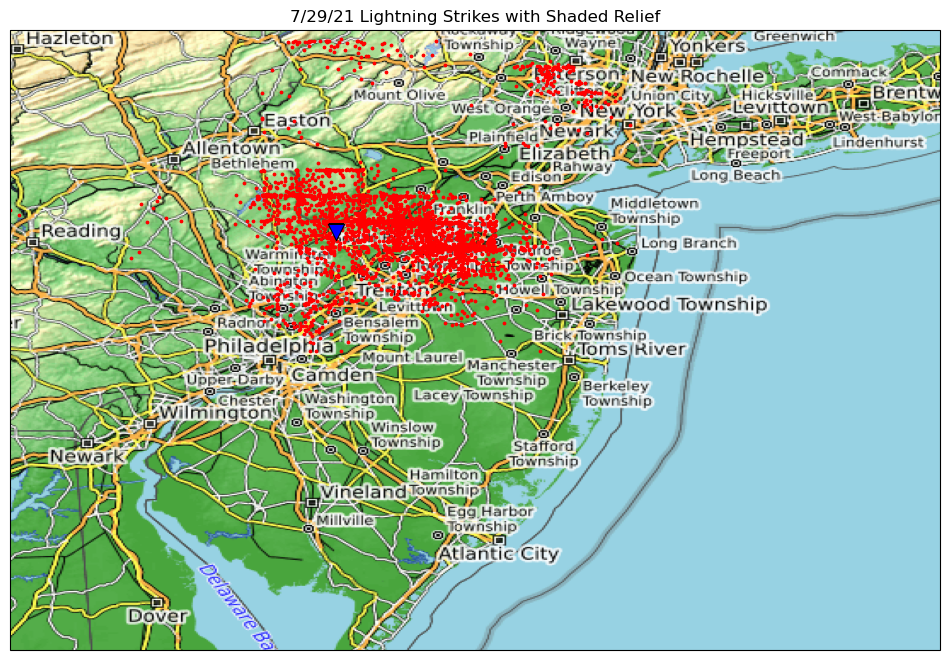

In [10]:
# inputs
lon_min, lon_max = -76, -73
lat_min, lat_max =  39,  41
zoom = 8 

# ---- 1) Compute tile index ranges with FLOOR ----
x_min, y_max = deg2num(lat_min, lon_min, zoom)  # SW corner
x_max, y_min = deg2num(lat_max, lon_max, zoom)  # NE corner

xs = list(range(min(x_min, x_max), max(x_min, x_max) + 1))
ys = list(range(min(y_min, y_max), max(y_min, y_max) + 1))

# Get Tiles
tiles = {}
for x in xs:
    for y in ys:
        url = f"https://tile.opentopomap.org/{zoom}/{x}/{y}.png"
        r = requests.get(url, timeout=15)
        r.raise_for_status()
        tiles[(x, y)] = Image.open(BytesIO(r.content))

# ---- 3) Stitch (Y increases south; first Y should go at the TOP) ----
# PIL image origin is upper-left, so the top row must be y_min.
tile_w, tile_h = next(iter(tiles.values())).size
W = len(xs) * tile_w
H = len(ys) * tile_h
background = Image.new("RGB", (W, H))

for x in xs:
    for y in ys:
        dx = (x - xs[0]) * tile_w
        dy = (y - ys[0]) * tile_h      # <-- keep this (no vertical flip!)
        background.paste(tiles[(x, y)], (dx, dy))

# ---- 4) Compute exact geographic extent of the stitched image (tile edges) ----
n = 2.0 ** zoom
def tile_x_to_lon(x):  return x / n * 360.0 - 180.0
def tile_y_to_lat(y):  # inverse WebMercator
    return math.degrees(math.atan(math.sinh(math.pi * (1 - 2*y/n))))

extent_tiles = [
    tile_x_to_lon(xs[0]),           # left
    tile_x_to_lon(xs[-1] + 1),      # right  (edge of the last tile)
    tile_y_to_lat(ys[-1] + 1),      # bottom (south edge)
    tile_y_to_lat(ys[0])            # top    (north edge)
]

# ---- 5) Plot (image in PlateCarree; lightning in PlateCarree) ----
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.imshow(background, extent=extent_tiles, origin="upper", transform=ccrs.PlateCarree())

# OPTIONAL: clip visible window to your requested bbox
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# lightning
ax.scatter(df_filtered.flash_lon, df_filtered.flash_lat, s=3, color="red", transform=ccrs.PlateCarree())

# Add triangle (tornado) marker at 40.35° N, -74.95° W
ax.scatter(
    -74.95, 40.35,
    s=140,
    marker="v",           # upside-down triangle
    color="blue",
    edgecolor="black",
    linewidth=0.8,
    transform=ccrs.PlateCarree(),
    zorder=10
)

plt.title("7/29/21 Lightning Strikes with Shaded Relief")
plt.show()

---

## Summary
After analyzing a number of events, it was difficult to visually determine a strong pattern of lightning distribution based on terrain features. This is somewhat expected, specific events with specific synoptic patterns will have to be assessed for the final project, and we expected greater correlations with tornado and wind strength than lightning.

### What's next?

## Resources and references

https://journals.ametsoc.org/view/journals/wefo/36/6/WAF-D-21-0018.1.xml

https://journals.ametsoc.org/view/journals/wefo/17/6/1520-0434_2002_017_1277_tiotot_2_0_co_2.xml